In [1]:
from k1lib.imports import *

In [2]:
class Network(nn.Module):
    def __init__(self, hiddenDim=10, hiddenLayers=2, relu=True):
        super().__init__()
        activation = lambda: nn.LeakyReLU() if relu else nn.Sigmoid()
        layers = []
        layers += [nn.Linear(1, hiddenDim), activation()]
        for i in range(hiddenLayers):
            layers += [nn.Linear(hiddenDim, hiddenDim), activation()]
        layers += [nn.Linear(hiddenDim, 1)]
        self.bulk = nn.Sequential(*layers)
    def forward(self, x):
        return self.bulk(x)

In [4]:
def newL(bs=64, optF=None, hiddenDim=10, simple=False):
    if optF == None: optF = lambda x: optim.SGD(x, lr=2e-4, momentum=0.9)
    if optF == "Adam": optF = lambda p: optim.Adam(p, lr=1e-2)
    l = k1lib.Learner()
    l.model = Network(hiddenDim=hiddenDim)
    l.data = k1lib.data.Data.fromDataset(k1lib.data.FunctionDataset.exp, bs)
    l.opt = optF(l.model.parameters())
    l.lossF = lambda x, y: ((x.squeeze() - y)**2).mean()
    #l.lossF = lambda x, y: (x**2).mean()
    if simple: l.cbs = k1lib.Callbacks().withProgressBar()
    l.cbs.withModifyBatch(lambda x, y: (x[:, None], y))
    l.cbs.withDType(torch.float32);
    def evaluate(self):
        xbs, ybs, ys = self.record(1, 3)
        xbs = torch.vstack(xbs).squeeze()
        ybs = torch.vstack([yb[:, None] for yb in ybs]).squeeze()
        ys = torch.vstack(ys).squeeze()
        #plt.plot(xbs, ybs, ".")
        plt.plot(xbs, ys.detach(), ".")
    l.evaluate = partial(evaluate, l)
    #l.cbs.withCancelOnLowLoss(1, epochMode=True)
    return l

In [5]:
hs = range(10, 100)
elapsedTimes = []
for h in hs:
    l = newL(optF="Adam", hiddenDim=h, simple=False)
    l.remove("Autosave")
    l.run(1);
    elapsedTimes.append(l.elapsedTime)
with open("complex.pth", "wb") as f: pickle.dump(k1lib.Object.fromDict({"hs": hs, "elapsedTimes": elapsedTimes}), f)

Progress:  74%, epoch: 0/1, batch:   23/31, elapsed:   0.47s  

In [7]:
hs = range(10, 100)
elapsedTimes = []
for h in hs:
    l = newL(optF="Adam", hiddenDim=h, simple=True)
    l.run(1);
    elapsedTimes.append(l.elapsedTime)
with open("simple.pth", "wb") as f: pickle.dump(k1lib.Object.fromDict({"hs": hs, "elapsedTimes": elapsedTimes}), f)

Progress:  74%, epoch: 0/1, batch:   23/31, elapsed:   0.28s  

## Analysis

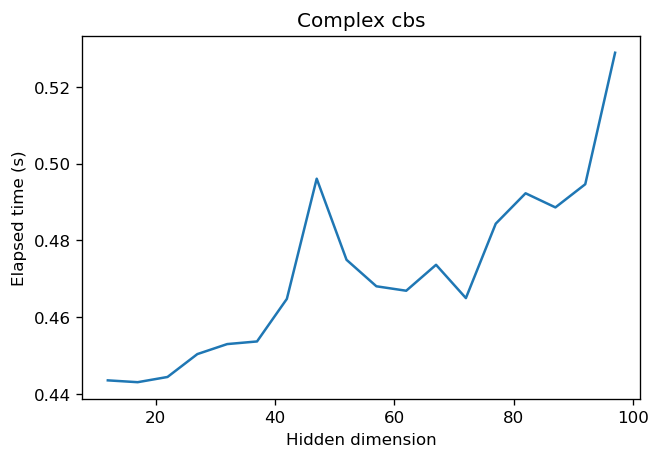

In [14]:
with open("complex.pth", "rb") as f: data = pickle.load(f)
plt.figure(dpi=120); plt.xlabel("Hidden dimension"); plt.ylabel("Elapsed time (s)"); plt.title("Complex cbs")
smooth = 5
plt.plot(k1lib.smooth(data.hs, smooth), k1lib.smooth(data.elapsedTimes, smooth));

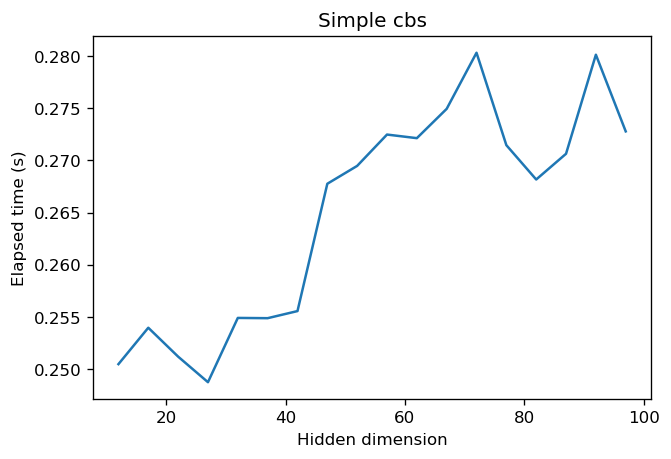

In [25]:
with open("simple.pth", "rb") as f: data = pickle.load(f)
plt.figure(dpi=120); plt.xlabel("Hidden dimension"); plt.ylabel("Elapsed time (s)"); plt.title("Simple cbs")
smooth = 5
plt.plot(k1lib.smooth(data.hs, smooth), k1lib.smooth(data.elapsedTimes, smooth));

Yeah you can probably get away with making the matmul operations much heavier, as it scale to that dimension much more. Also notice how the increased time doesn't increase linearly at all (12-15% increase while ops increases 100 times)